In [10]:
# Custom classes
from pandasgui import show
from DFInfo import DataFrameInfo
from db_util import RDSDatabaseConnector
from GraphPlotter import Plotter
from DFTransform import DataFrameTransform
from DTransform import DataTransform

# modules
import warnings, os
import pandas as pd

# to stop spam of deprecated feature
warnings.simplefilter(action="ignore", category=FutureWarning) 

#creates all the classes
rdsdbc = RDSDatabaseConnector()
dtransformer = DataTransform()
dfinfo = DataFrameInfo()
dftransformer = DataFrameTransform()
plotter = Plotter()

available_list = ["policy_code"]
string_list = ["policy_code", "term"]
strip_list = ["term"]
qualitative_list = ["purpose", "grade", "sub_grade","home_ownership", "verification_status", "loan_status", "payment_plan", "application_type", "employment_length"]
outlier_columns = ["funded_amount", "funded_amount_inv", "installment", "open_accounts", "delinq_2yrs", "total_accounts", "total_payment", "total_payment_inv", "total_rec_prncp", "total_rec_int", "last_payment_amount"]
ignore_transform_list = ["funded_amount", "funded_amount_inv"]

dtransformer.set_available_list(available_list)
dtransformer.set_string_list(string_list)
dtransformer.set_strip_list(strip_list)
dtransformer.set_qualitative_list(qualitative_list)

dataframe = rdsdbc.download_df()
dataframe = dtransformer.call_all_cleaners(dataframe)

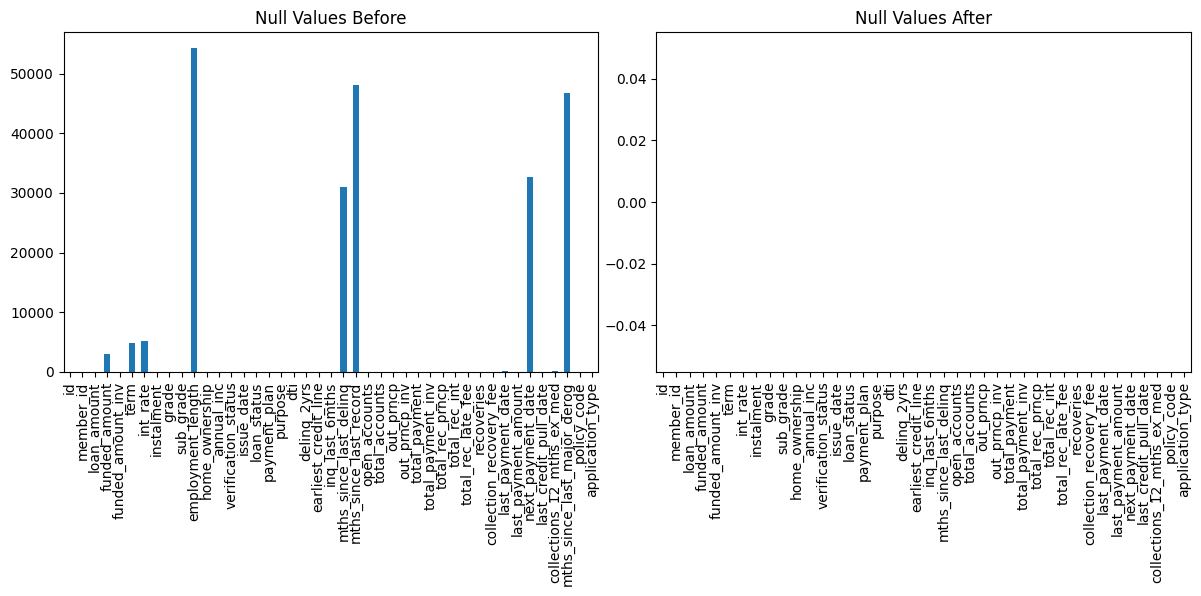

In [12]:
#calls the plotter and visualises the null value removal
nulls_before = dftransformer.count_nulls(dataframe)
dataframe = dftransformer.drop_columns(dataframe, 0.5)
dataframe = dftransformer.impute_columns(dataframe)
nulls_after = dftransformer.count_nulls(dataframe)

plotter.plot_nulls_before_after(nulls_before, nulls_after)

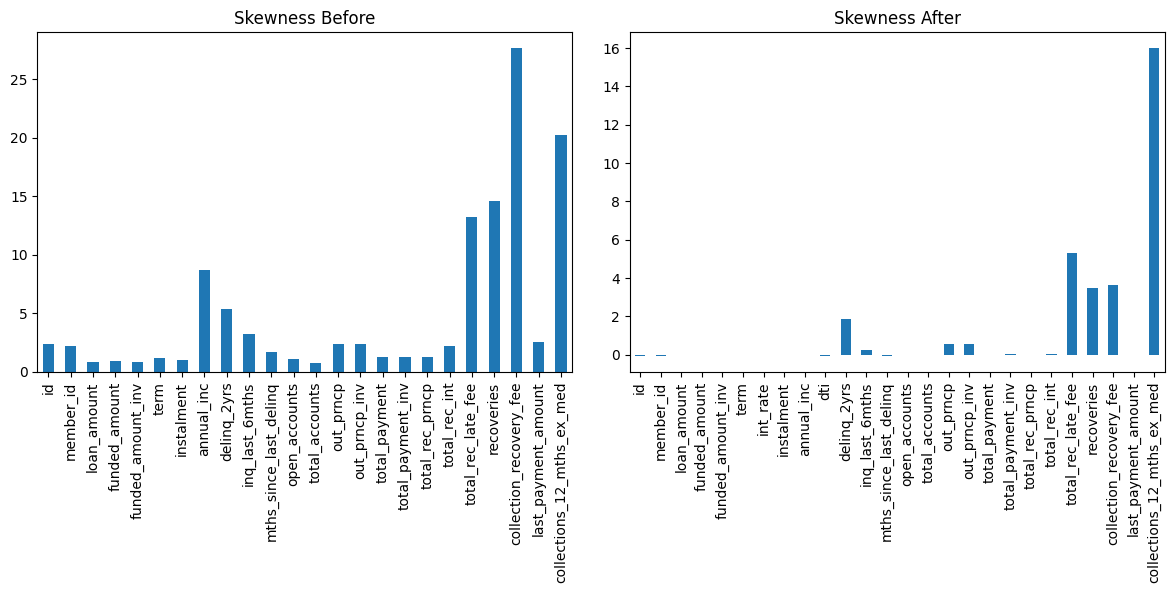

In [13]:
skewed_columns = dtransformer.get_skewed_columns(dataframe, qualitative_list, 0.5)
skewed_dataframe = dtransformer.get_skewed_dataframe(dataframe, skewed_columns)
unskewed_dataframe, transformation_methods = dftransformer.remove_skewness(dataframe, qualitative_list)

plotter.plot_skewed_vs_unskewed_graph(skewed_dataframe.skew(), unskewed_dataframe.skew())

In [14]:
combined_df = dftransformer.merge_dataframes(dataframe, unskewed_dataframe)
combined_df.to_csv(os.path.join("script_data", "combined_dataframe.csv"), index=False)
dataframe = combined_df

In [15]:

plotter.visualise_outliers(dataframe, outlier_columns, False)
before = dataframe
drop_outlier_dictionary = dftransformer.find_closest_outliers(dataframe, outlier_columns)
dataframe = dftransformer.drop_outside_bounds(dataframe, drop_outlier_dictionary)
after = dataframe

{'funded_amount': [24.453829821679996, 115.06849497250653], 'funded_amount_inv': [17.279599292626045, 265.9954340190318], 'delinq_2yrs': [0.0, 0.0], 'open_accounts': [1.2280036297572594, 4.927722893276135], 'total_accounts': [1.943713406668464, 10.339958349945427], 'total_payment': [18.16696542714226, 94.22519386585464], 'total_payment_inv': [16.597575849670996, 154.19070811610203], 'total_rec_prncp': [14.157311768535312, 99.09518088660506], 'total_rec_int': [5.701891453040924, 27.74476786047848], 'last_payment_amount': [2.0480977258675543, 10.800207153791257]}


In [16]:
count_before = dftransformer.calculate_outlier_counts(before, outlier_columns)
count_after = dftransformer.calculate_outlier_counts(after, outlier_columns)
before_dataframe = pd.DataFrame(data = count_before, index = [0])
after_dataframe = pd.DataFrame(data = count_after, index = [0])

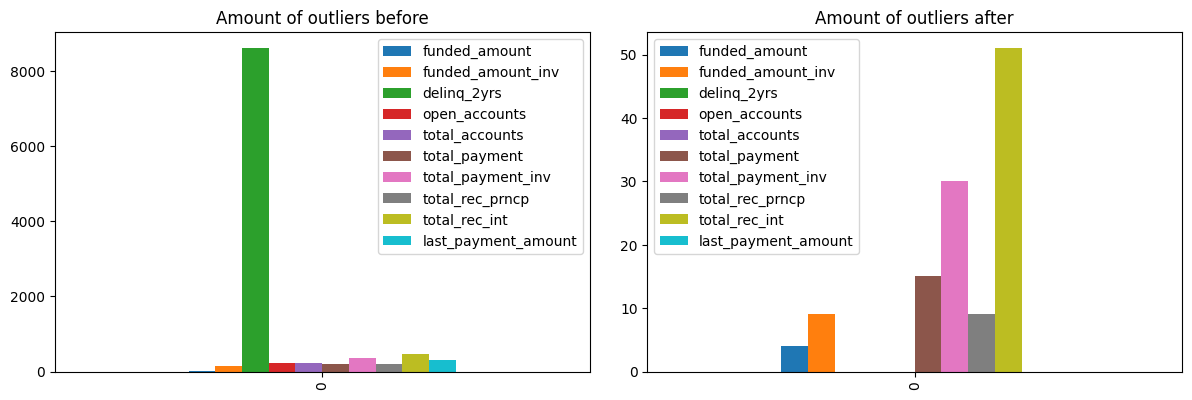

In [17]:
plotter.plot_outliers_before_after(before_dataframe, after_dataframe)

Columns dropped:['member_id', 'funded_amount', 'funded_amount_inv', 'instalment', 'total_payment', 'total_payment_inv', 'total_rec_int', 'out_prncp_inv', 'collection_recovery_fee']


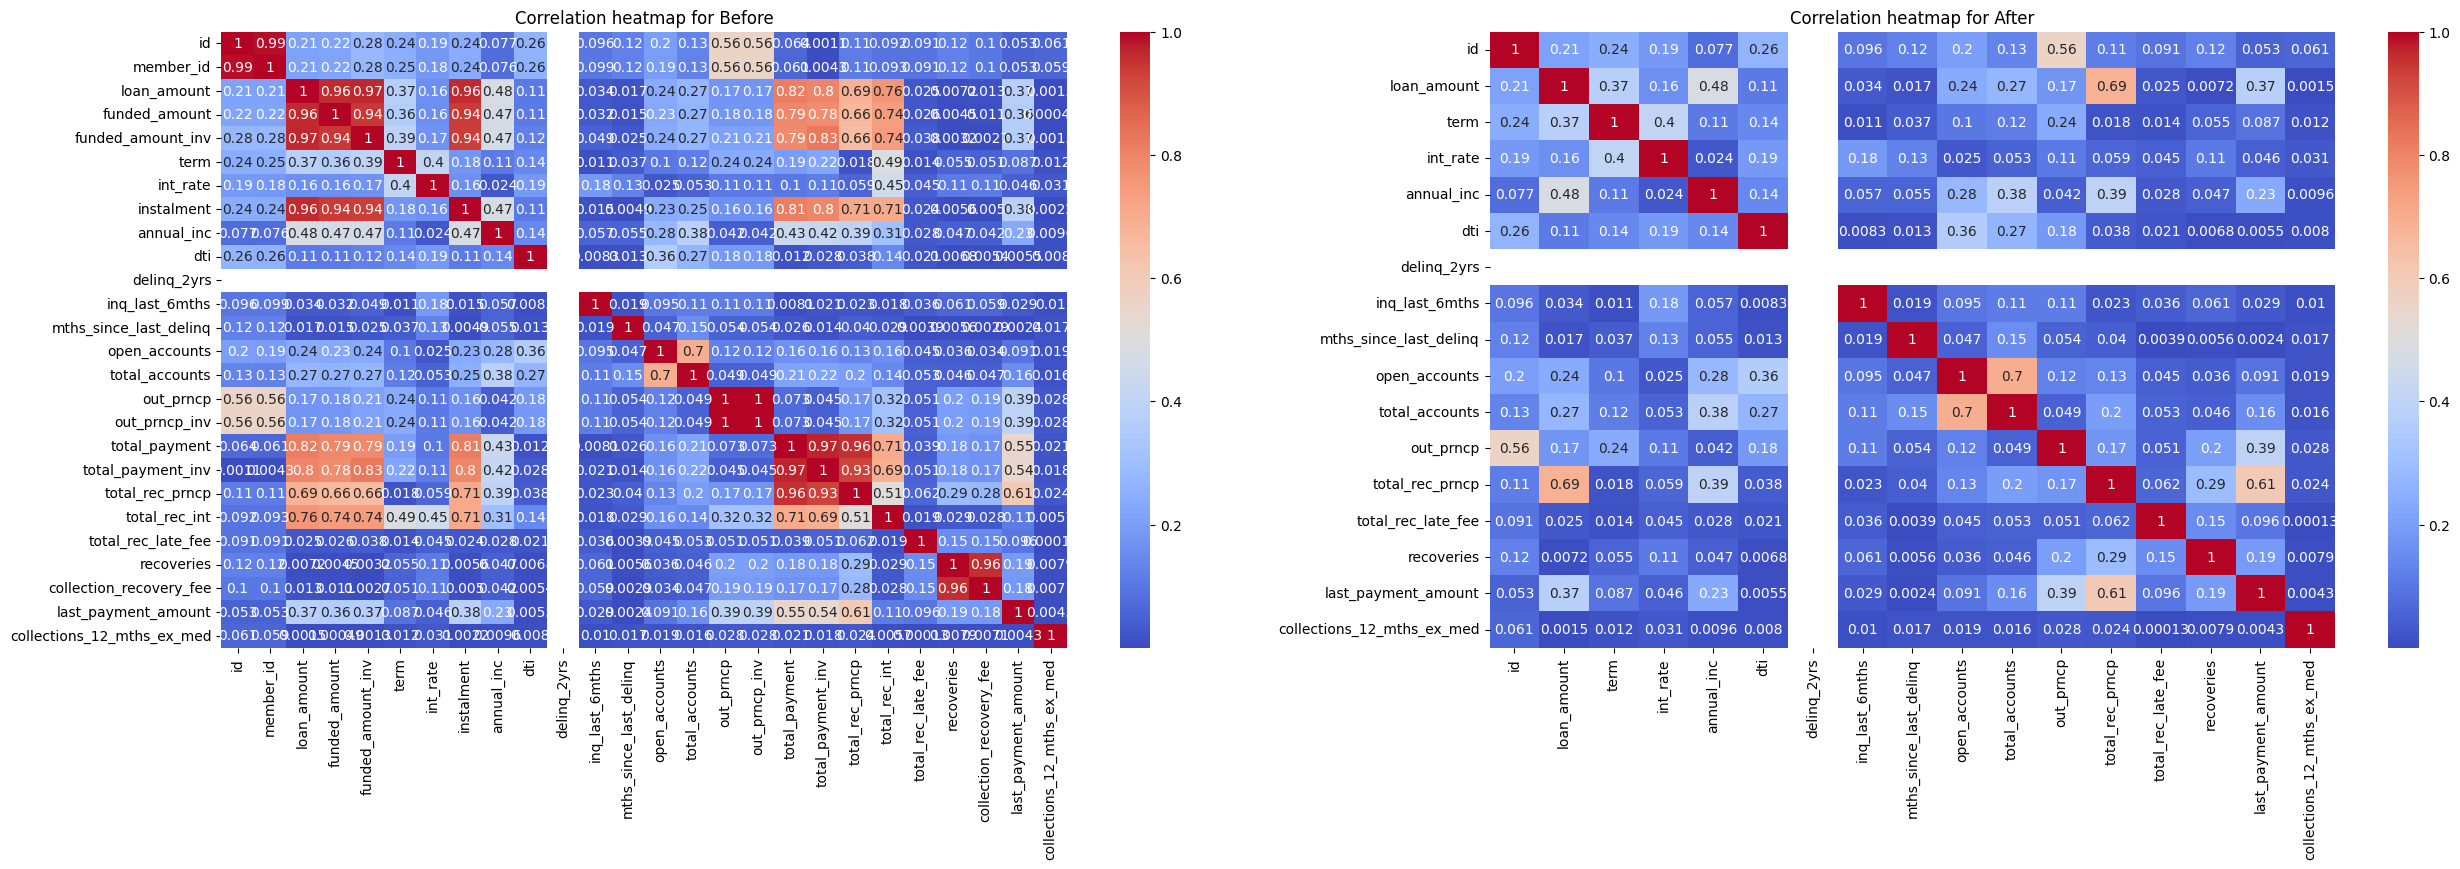

In [18]:

matrix_before = dftransformer.get_correlation_matrix(dataframe)
dataframe = dftransformer.drop_overcorrelated(dataframe, matrix_before)
matrix_after = dftransformer.get_correlation_matrix(dataframe)
plotter.plot_correlation_before_after(matrix_before, matrix_after)